### Johdanto datatieteeseen
# Tampereen kaksiot

Tämän notebookin tarkoituksena on raapia dataa Tampereen kaksioista Etuovi.com -sivustolta, siistiä sitä, tunnistaa merkittävät ominaisuudet, sekä luoda pari erilaista regressiomallia sen pohjalta. Ratkaistavia esimerkkiongelmiani ovat:
* Regressio-ongelma: Olen myymässä omistusasuntoa Tampereella, enkä tiedä millaisessa hintaluokassa asuntoni kaltaiset kohteet pyörii.

* Luokitteluongelma: Olen etsimässä uutta omistusasuntoa Tampereelta, ja haluaisin tietää mistä päin kaupunkia voisin löytää haluamani kaltaisen asunnon.

## Tarvittavat kirjastot

In [35]:
# Tarvittavien kirjastojen tuominen.
from bs4 import BeautifulSoup as bs
from IPython.display import clear_output
from requests import get
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, os

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
current_time = time.time()

le = LabelEncoder()

print('Done importing')

Done importing


## Datan raapiminen

In [36]:
# Raapimiseen tarvittavien taustatietojen hakeminen, ja määrittäminen.
useLocal = True
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])
print('Parameters set.')

Parameters set.


In [37]:
# Datan raavinta. Jos raavittu csv-tiedosto löytyy, käytetään sitä.
if useLocal:
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481187938&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
            spans = temp.find_all('span', class_='')

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area)
            data['Osoite'].append(address)
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type)
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'),'Scraping data...')
        
    df = pd.DataFrame(data)
    if fileName in os.listdir('./data/'):
        local_df = pd.read_csv('./data/tampere_kaksiot_etuovi.csv')
        os.rename('./data/tampere_kaksiot_etuovi.csv', './data/tampere_kaksiot_etuovi.csv.old')
        pd.concat([df,local_df]).drop_duplicates().reset_index(drop=True)
    df.to_csv('./data/tampere_kaksiot_etuovi.csv')
    print('Done scraping',)
print(f'{len(df)} rows loaded.')

Local data found! Imported to DataFrame.
968 rows loaded.


Nyt raavittu data on käytettävissä pandas-kirjaston hyödyllisessä DataFrame -taulukkoformaatissa. Nyt voidaan jatkaa datan tarkasteluun ja siistimiseen.


## Datan tarkastelu ja siistiminen

In [38]:
df.head()

Alue                Osoite     Hinta  Koko   Vuosi  Talotyyppi  \
0       Amuri  Kortelahdenkatu 18 B  174000.0  40.0  1970.0  Kerrostalo   
1      Kaleva         Sammonkatu 37  219000.0  53.5  1957.0  Kerrostalo   
2      Kaleva  Kalevan puistotie 11  183000.0  50.0  1955.0  Kerrostalo   
3      Kaleva         Sammonkatu 37  186000.0  42.5  1957.0  Kerrostalo   
4  Santalahti      Rantatie 37 C 56  181800.0  38.0  2019.0  Kerrostalo   

   Sauna  Parveke  
0  False    False  
1  False    False  
2  False    False  
3  False    False  
4  False    False

In [39]:
# Tilastollisia tietoja datan numeerisista muuttujista
df.describe()

Hinta        Koko        Vuosi
count     968.000000  967.000000   967.000000
mean   213867.668388   47.389555  2008.499483
std     82603.520970    9.525234    23.015877
min         0.000000   22.000000  1920.000000
25%    159000.000000   39.500000  2012.000000
50%    199250.000000   46.500000  2020.000000
75%    248230.000000   54.000000  2021.000000
max    708550.000000   93.500000  2022.000000

In [40]:
# Tietoja datasarakkeiden määristä ja tyypeistä
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 0 to 967
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        968 non-null    object 
 1   Osoite      968 non-null    object 
 2   Hinta       968 non-null    float64
 3   Koko        967 non-null    float64
 4   Vuosi       967 non-null    float64
 5   Talotyyppi  968 non-null    object 
 6   Sauna       968 non-null    bool   
 7   Parveke     968 non-null    bool   
dtypes: bool(2), float64(3), object(3)
memory usage: 54.8+ KB


Viimeisimmän komennon tulosteesta voidaan nähdä joissakin sarakkeissa olevan puuttuvia arvoja (22.4.2020). Korvataan puuttuvat numeeriset arvot aluekohtaisilla keskiarvoilla.

In [41]:
colsWithNan = df.columns[df.isna().any()].tolist()

for col in colsWithNan:
    df[col].fillna(round(df[col].mean()), inplace=True)

df.Vuosi = df.Vuosi.astype('int')
""" df.Sauna = df.Sauna.astype('int')
df.Parveke = df.Parveke.astype('int') """
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 0 to 967
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        968 non-null    object 
 1   Osoite      968 non-null    object 
 2   Hinta       968 non-null    float64
 3   Koko        968 non-null    float64
 4   Vuosi       968 non-null    int32  
 5   Talotyyppi  968 non-null    object 
 6   Sauna       968 non-null    bool   
 7   Parveke     968 non-null    bool   
dtypes: bool(2), float64(2), int32(1), object(3)
memory usage: 51.0+ KB


Nyt puuttuvia arvoja ei enää ole. Visualisoidaan seuraavaksi hiukan datan sisältöä.

In [42]:
df['m2-hinta'] = df.Hinta / df.Koko

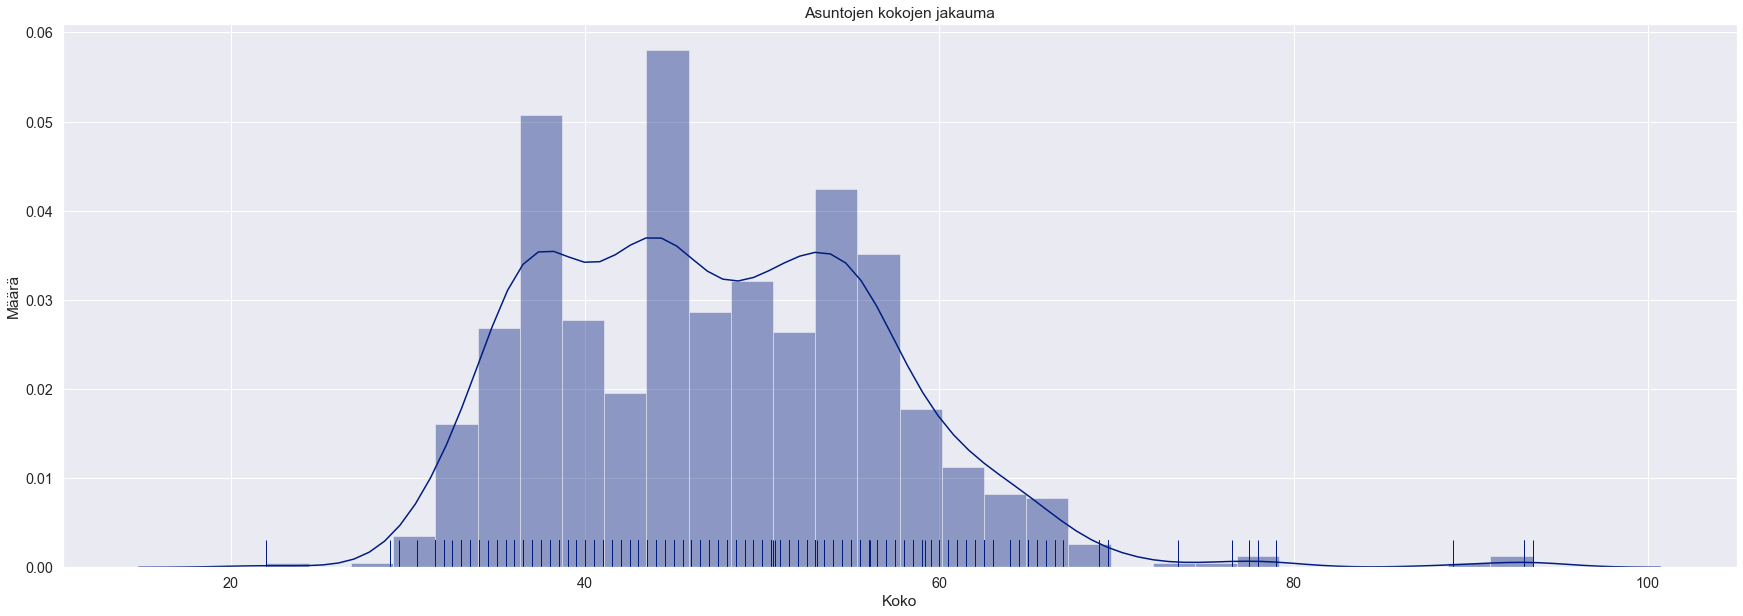

In [77]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen kokojen jakauma')
plt.xlabel('Asunnon koko neliömetreissä')
plt.ylabel('Määrä')
#df['Koko'].value_counts().plot(kind='bar');
sns.distplot(df.Koko, rug=True, bins=30);

Asuntojen koot asettuvat pääosin 30 ja 70 neliömetrin välille.

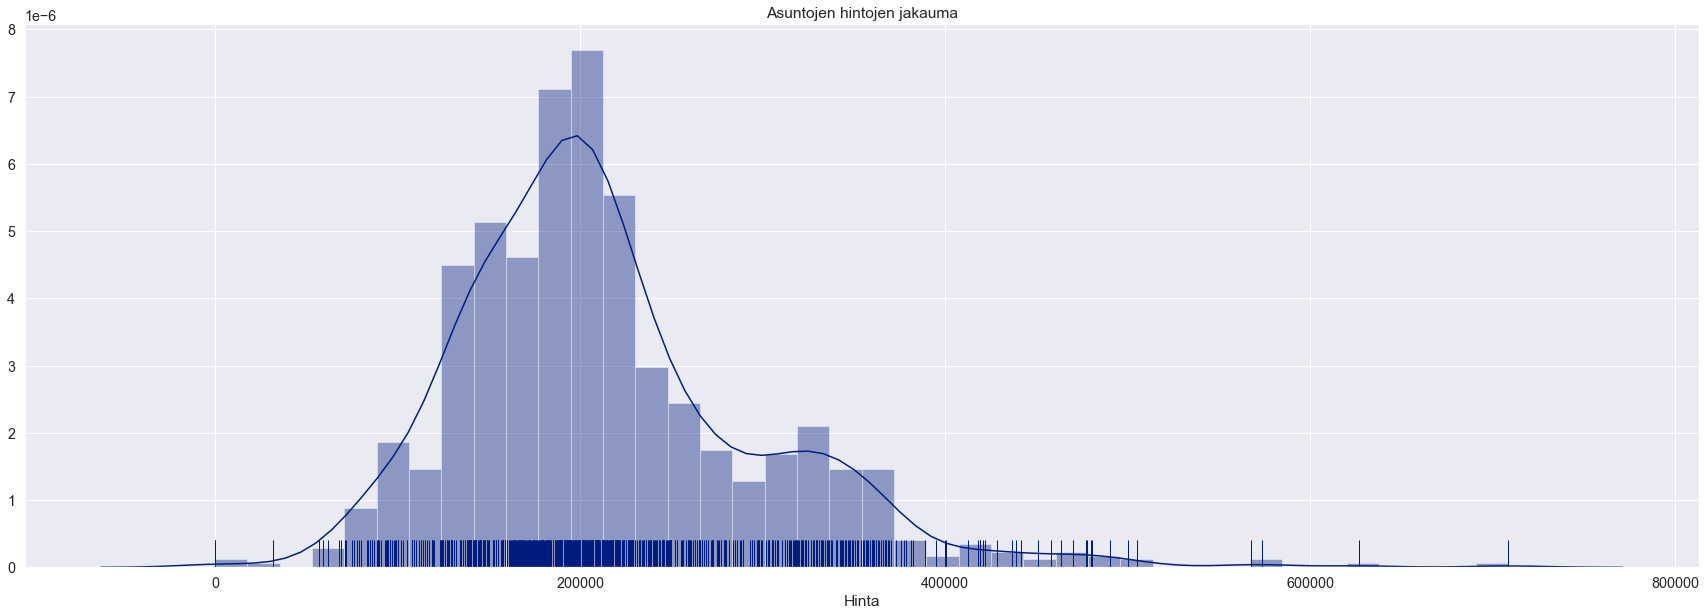

In [78]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen hintojen jakauma')
sns.distplot(df['Hinta'], rug=True);

Hinnat painottuvat vahvasti 200 000 euron ympäristöön.

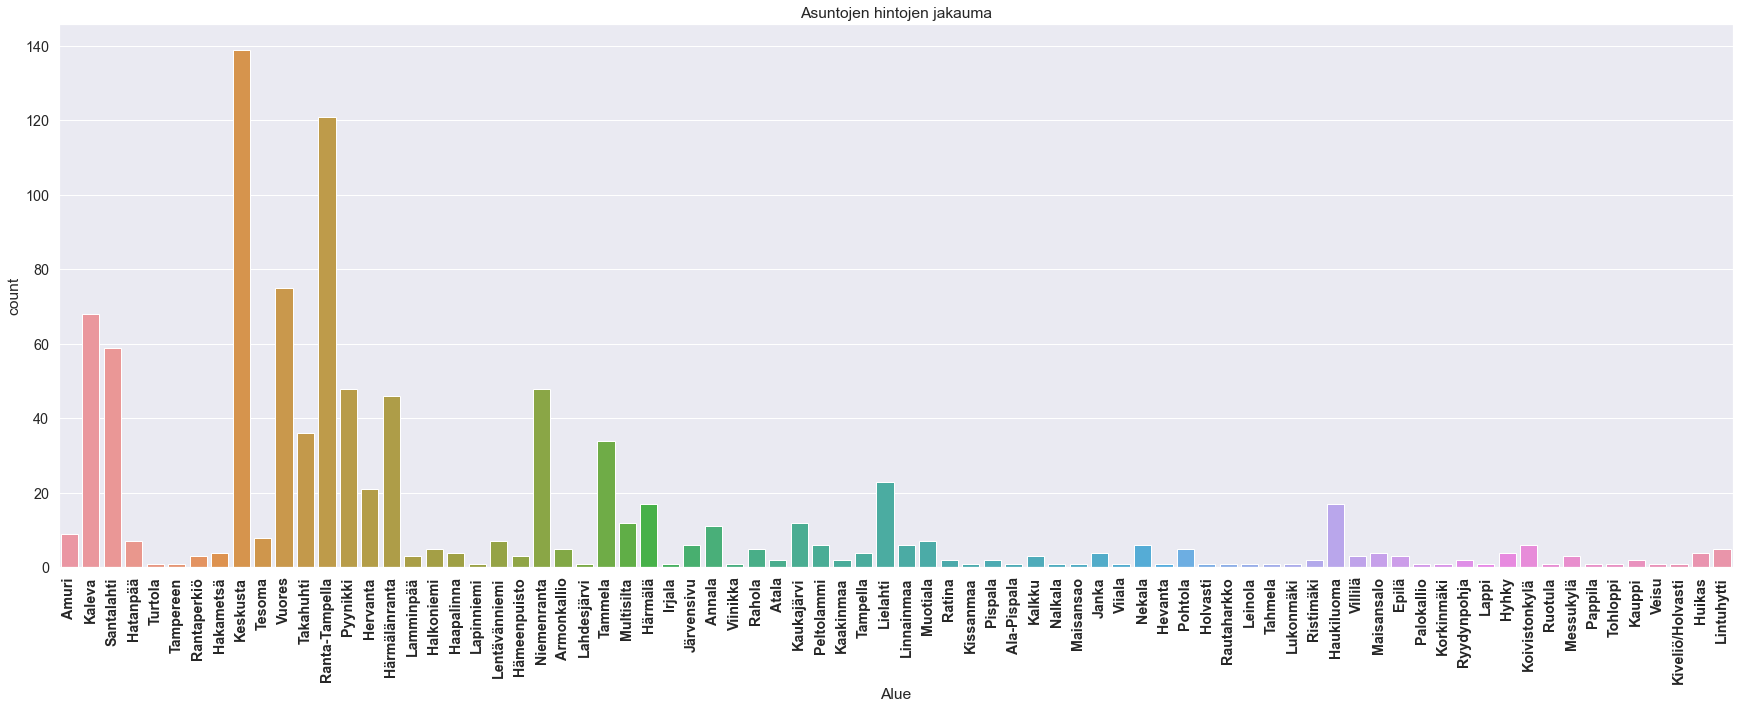

In [76]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen hintojen jakauma')
sns.countplot(x=df.Alue)
plt.xticks(weight='bold',rotation=90,);

Nähdään aluekohtaisten ilmoitusmäärien erojen olevan suuria.

In [46]:
df[df.Alue == 'Ranta-tampella']

Empty DataFrame
Columns: [Alue, Osoite, Hinta, Koko, Vuosi, Talotyyppi, Sauna, Parveke, m2-hinta]
Index: []

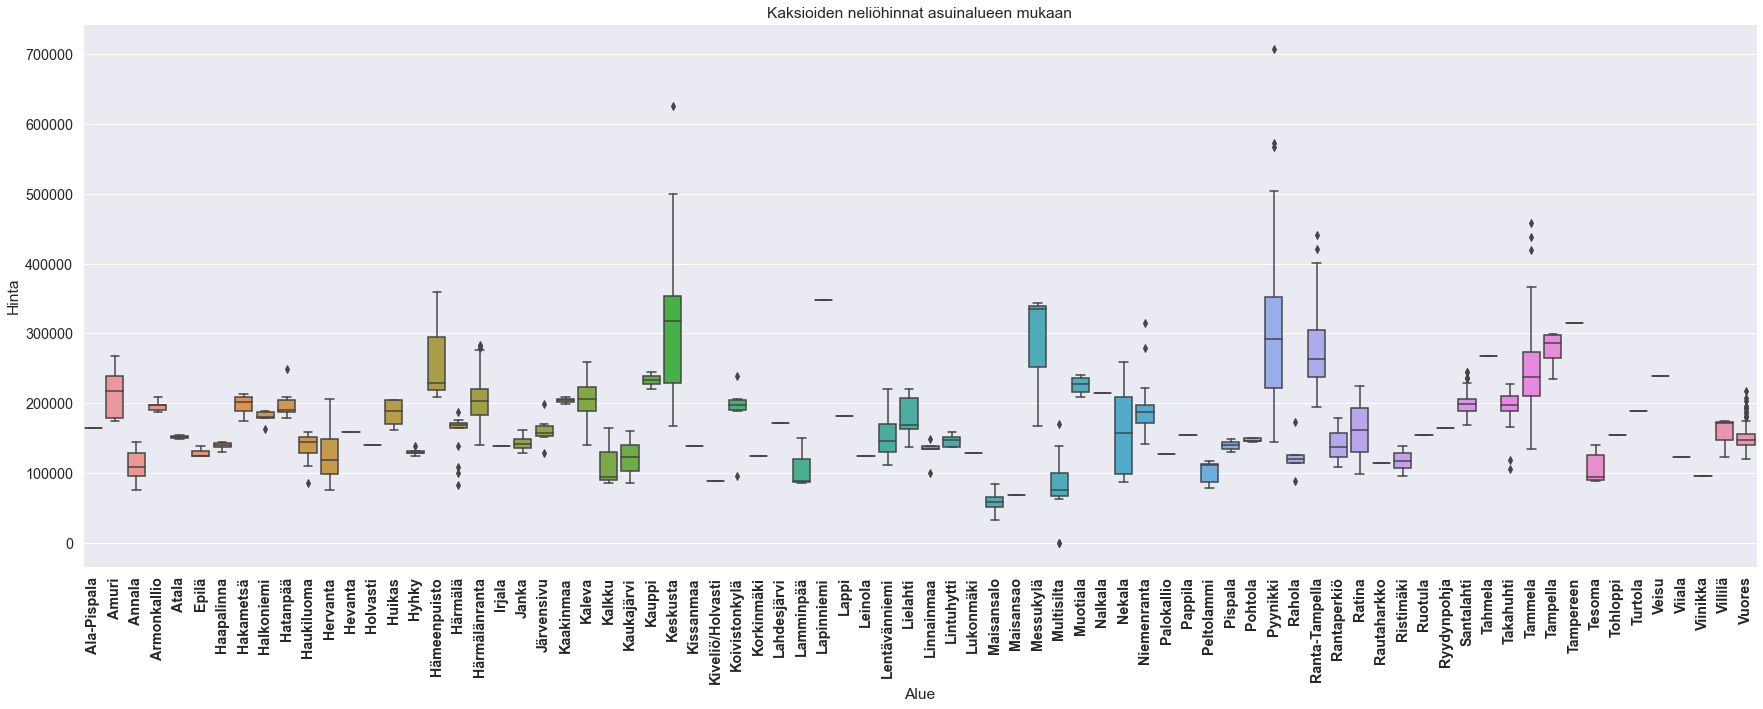

In [72]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Alue.sort_values(ascending=True), y=df['Hinta'],);
plt.title('Kaksioiden neliöhinnat asuinalueen mukaan')
plt.xticks(weight='bold',rotation=90);

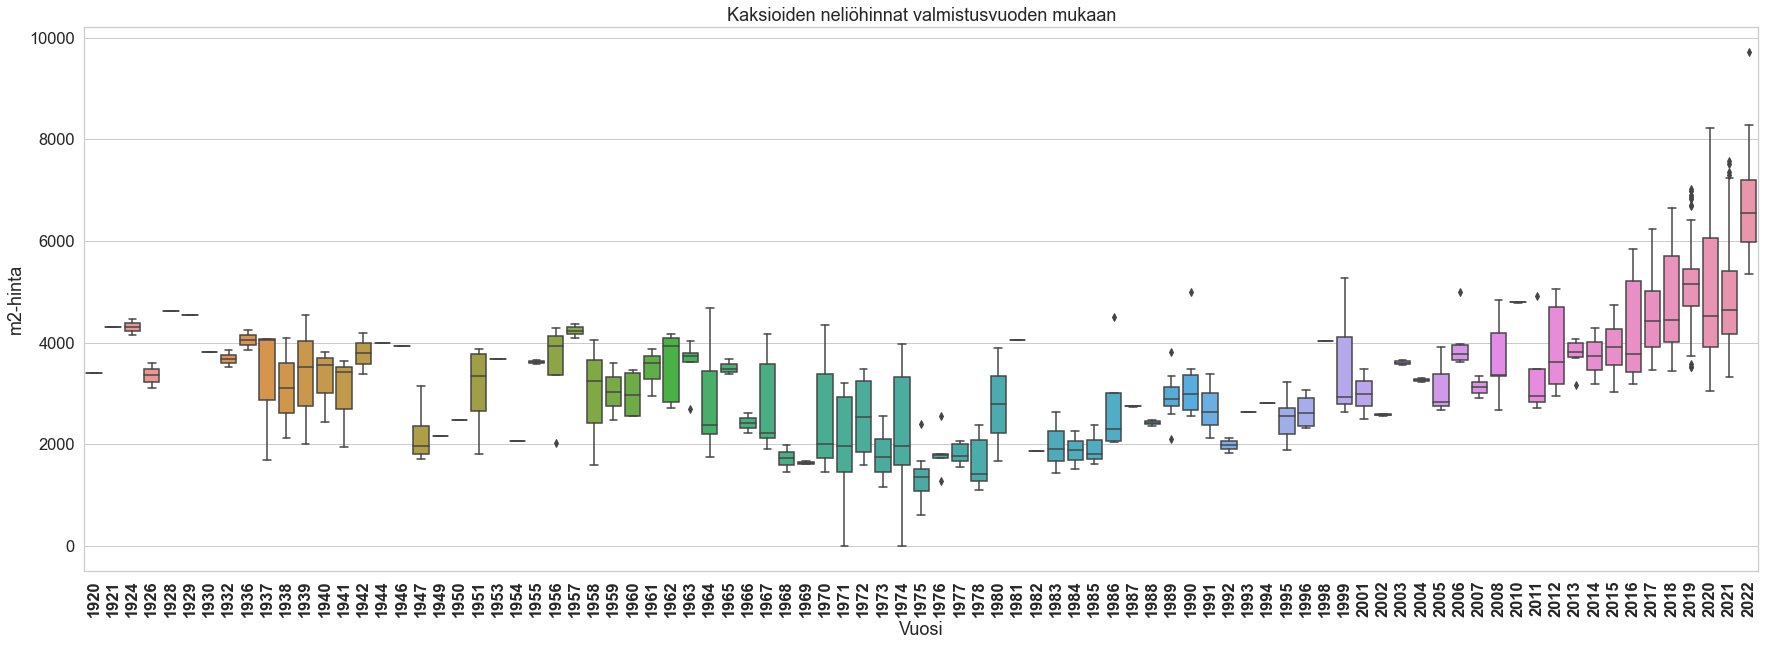

In [48]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Vuosi, y=df['m2-hinta']);
plt.title('Kaksioiden neliöhinnat valmistusvuoden mukaan')
plt.xticks(weight='bold',rotation=90);

Myytävänä olevat asunnot ovat kuvaajan perusteella hyvin uusia, ja osa jopa vielä rakennuksvaiheessa olevia. Hinnat näyttävät muodostavan U-muotoa, eli 70-luvulla rakennettujen asuntojen hinnat vaikuttavat olevan matalimpia, ja siitä vanhempien ja uudempien asuntojen hinnat kasvavat. 

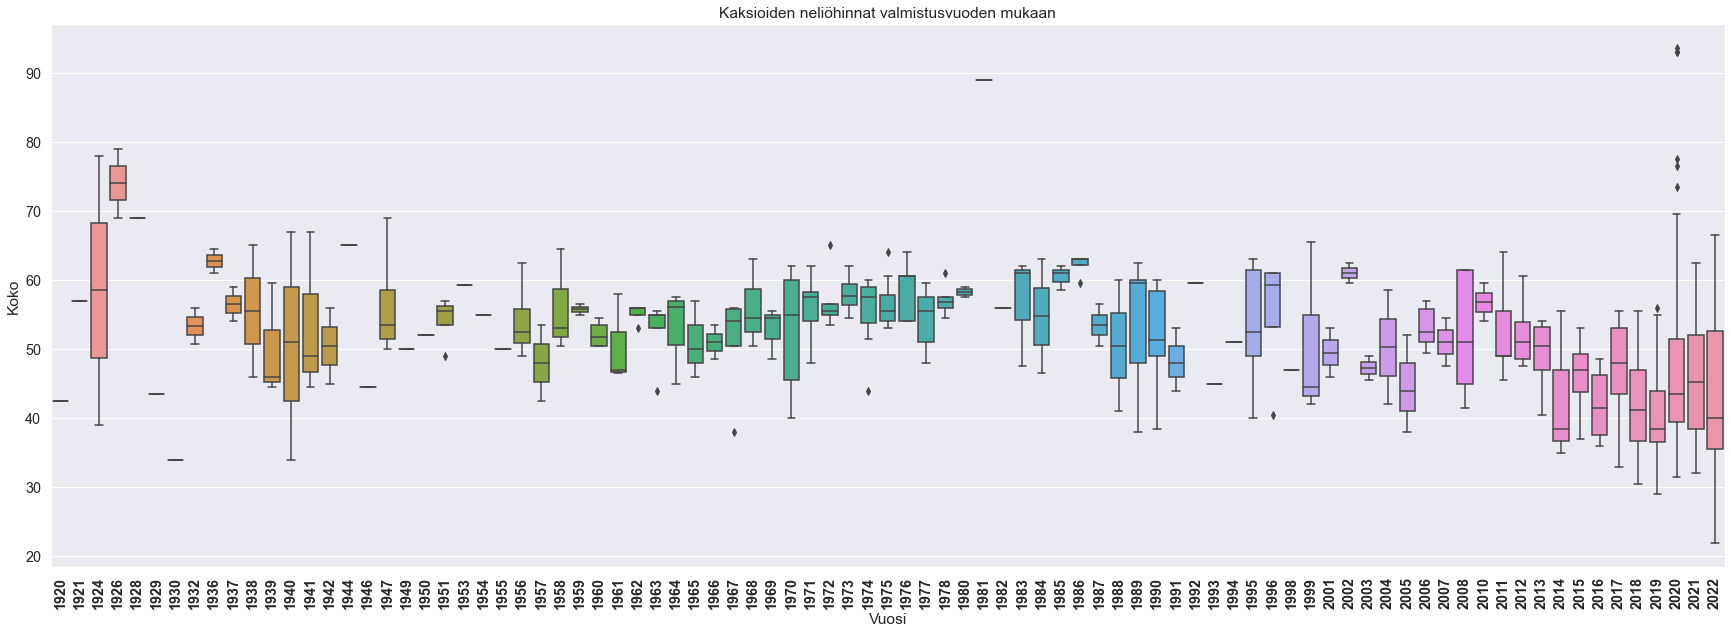

In [83]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Vuosi, y=df['Koko']);
plt.title('Kaksioiden neliöhinnat valmistusvuoden mukaan')
plt.xticks(weight='bold',rotation=90);

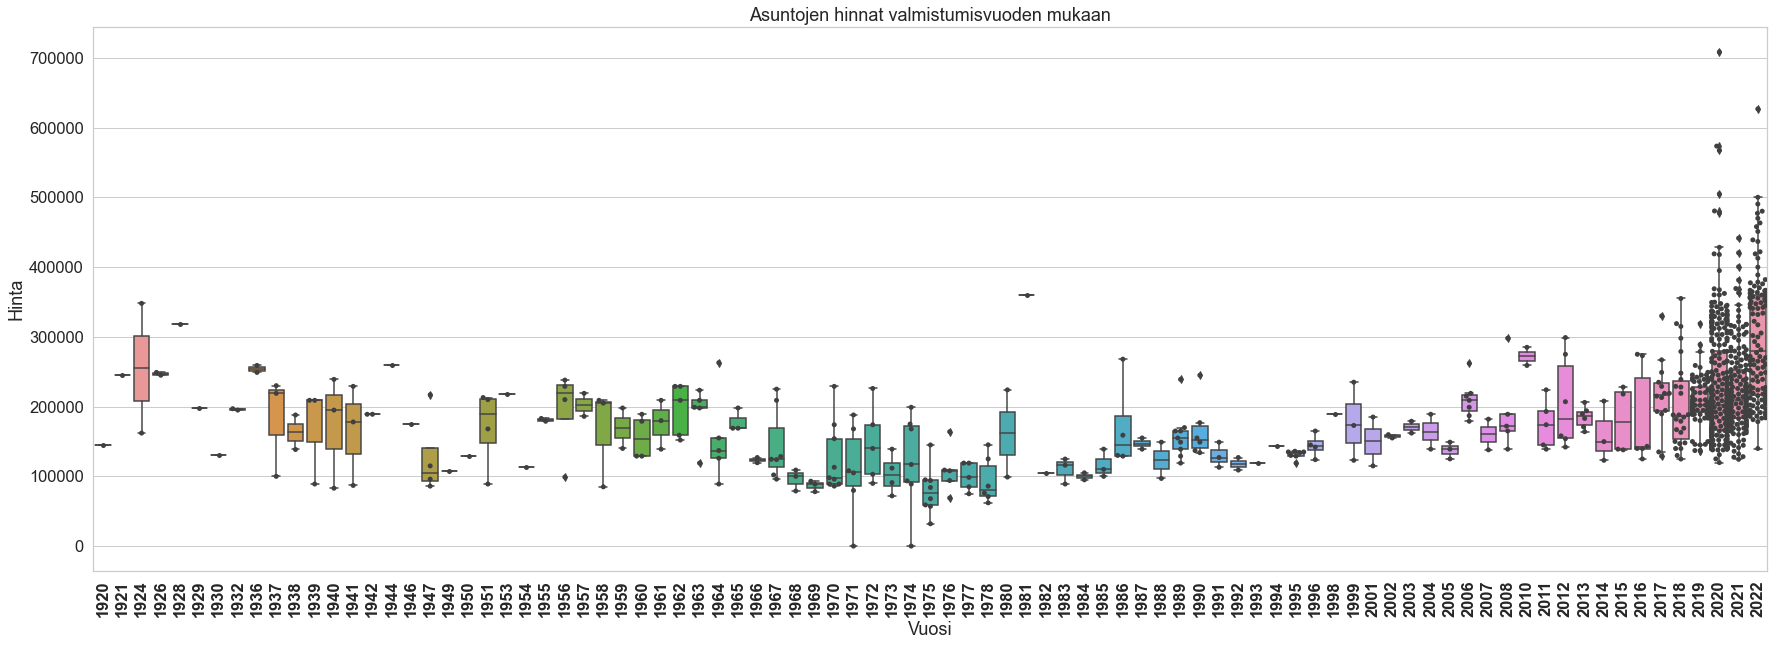

In [45]:
plt.figure(figsize=(30,10))

sns.boxplot(x='Vuosi', y="Hinta", data=df,)
sns.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25",)
plt.title('Asuntojen hinnat valmistumisvuoden mukaan');
plt.xticks(weight='bold',rotation=90,);

<Figure size 1440x1440 with 0 Axes>

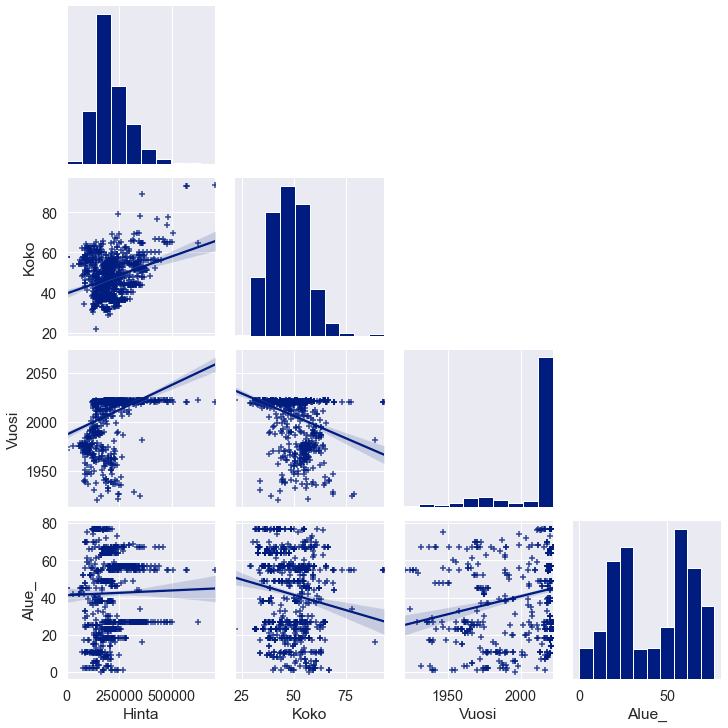

In [88]:
plt.figure(figsize=(20,20));
#pd.plotting.scatter_matrix(df[['Hinta','Koko', 'Vuosi']], c='red');
sns.pairplot(df[['Hinta','Koko', 'Vuosi', 'Alue_']], corner=True, kind='reg', markers='+');

## Oleellisten piirteiden tunnistaminen

Aloitetaan korvaamalla kategoriset muuttujat numeerisilla korvikkeilla.

In [50]:
print(f'Before\n{df.dtypes}')

for col in df.columns:
    if df[col].dtype == 'object' and col != 'Osoite':
        newColName = f'{col}_'
        fit = le.fit(df[col])
        df[newColName] = fit.transform(df[col])
print(f'\nAfter\n{df.dtypes}')

Before
Alue           object
Osoite         object
Hinta         float64
Koko          float64
Vuosi           int32
Talotyyppi     object
Sauna            bool
Parveke          bool
m2-hinta      float64
dtype: object

After
Alue            object
Osoite          object
Hinta          float64
Koko           float64
Vuosi            int32
Talotyyppi      object
Sauna             bool
Parveke           bool
m2-hinta       float64
Alue_            int32
Talotyyppi_      int32
dtype: object


In [51]:
df.head(10)

Alue                   Osoite     Hinta  Koko  Vuosi  Talotyyppi  \
0        Amuri     Kortelahdenkatu 18 B  174000.0  40.0   1970  Kerrostalo   
1       Kaleva            Sammonkatu 37  219000.0  53.5   1957  Kerrostalo   
2       Kaleva     Kalevan puistotie 11  183000.0  50.0   1955  Kerrostalo   
3       Kaleva            Sammonkatu 37  186000.0  42.5   1957  Kerrostalo   
4   Santalahti         Rantatie 37 C 56  181800.0  38.0   2019  Kerrostalo   
5     Hatanpää  Hatanpään puistokuja 29  249000.0  50.0   2017  Kerrostalo   
6      Turtola          Sotilaankuja 11  189000.0  58.5   2004   Luhtitalo   
7    Tampereen      Itsenäisyydenkatu 3  315000.0  47.5   2018  Kerrostalo   
8  Rantaperkiö          Pihlajakatu 6 A  179000.0  49.5   2006  Kerrostalo   
9    Hakametsä         Uudenkylänkatu 4  174000.0  53.5   1972  Kerrostalo   

   Sauna  Parveke     m2-hinta  Alue_  Talotyyppi_  
0  False    False  4350.000000      1            0  
1  False    False  4093.457944     23            0  
2  False    False  3660.000000     23            0  
3  False    False  4376.470588     23            0  
4  False    False  4784.210526     64            0  
5  False    False  4980.000000      9            0  
6   True    False  3230.769231     72            1  
7  False    False  6631.578947     69            0  
8  False    False  3616.161616     58            0  
9  False    False  3252.336449      7            0

In [69]:
df.describe()

Hinta        Koko        Vuosi     m2-hinta       Alue_  \
count     968.000000  968.000000   968.000000   968.000000  968.000000   
mean   213867.668388   47.389153  2008.498967  4596.383330   42.331612   
std     82603.520970    9.520316    23.003979  1578.960335   21.610651   
min         0.000000   22.000000  1920.000000     0.000000    0.000000   
25%    159000.000000   39.500000  2012.000000  3617.676768   23.000000   
50%    199250.000000   46.500000  2020.000000  4418.209877   46.000000   
75%    248230.000000   54.000000  2021.000000  5747.763936   57.000000   
max    708550.000000   93.500000  2022.000000  9717.674419   77.000000   

       Talotyyppi_  
count   968.000000  
mean      0.145661  
std       0.739254  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       5.000000

### Korrelaatioanalyysi

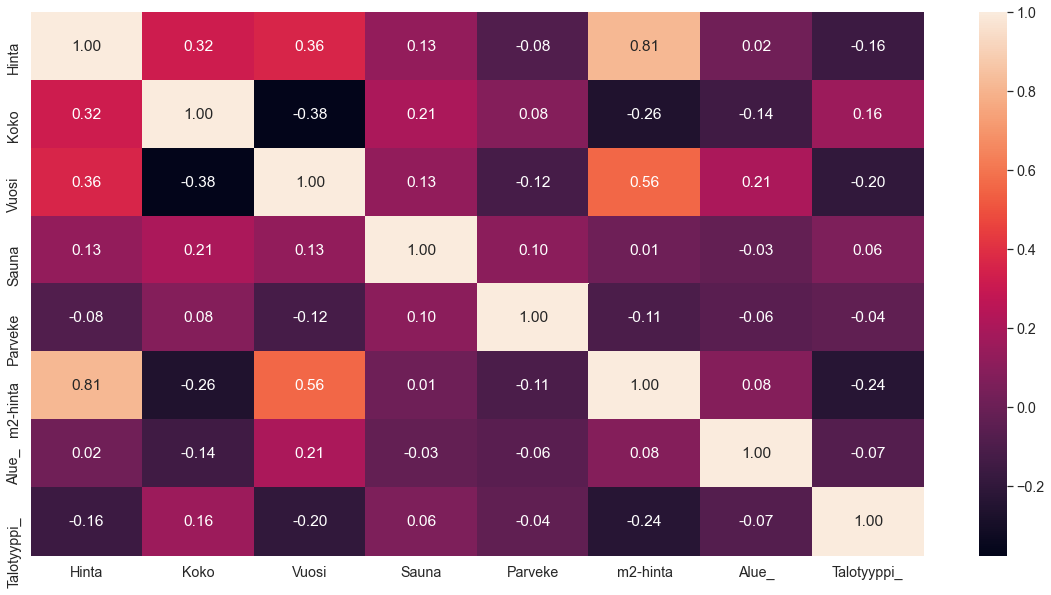

In [52]:
sns.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_df,annot=True,fmt='.2f');

Erotellaan listaan korrelaatiot, jotka ovat suurempia kuin 0.1 ja pienempiä kuin 0.8, tai pienempiä kuin -0.1.

In [53]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        print(key, round(value,5))
        important_cols.append(key)

Vuosi 0.36316
Koko 0.32035
Sauna 0.13087
Talotyyppi_ -0.1604


Sarakkeiden korrelaatiot eivät tällä hetkellä ole kovin vahvoja, mutta valmistumisvuosi näyttäisi korreloivan eniten hinnan kanssa.

### Chi2-analyysi

Kokeillaan erotella tärkeitä piirteitä sklearn-kirjastoon sisältyvällä SelectKBest-funktion avulla.

In [54]:
y = df.Hinta.astype('int')
X = df.drop(['Hinta', 'Alue', 'Osoite', 'Talotyyppi'], axis=1)

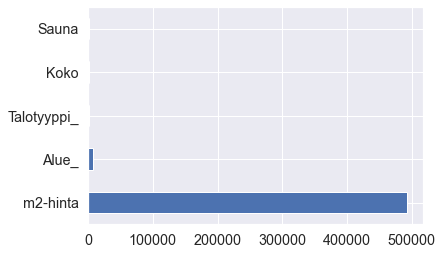

In [55]:
kbest = SelectKBest(score_func=chi2, k=len(X.columns))
kbest.fit(X,y)

feat_score = pd.Series(kbest.scores_, index=X.columns)
feat_score.nlargest().plot(kind='barh');

Tämän testin perusteella asunnon alue olisi huomattavasti merkittävin piirre. 

#### ExtraTreesClassifier -testi
Tämä testi pohjautuu sklearn-kirjaston ExtraTreesClassifier-funktioon. Se muodostaa sarakkeille tärkeyskertoimia, jolloin suurempi arvo on merkki tärkeämmästä piirteestä.

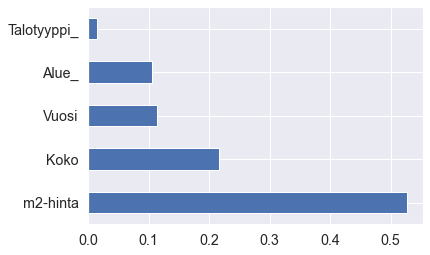

In [56]:
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest().plot(kind='barh');

Tämänkin testin perusteella asunnon koko olisi tärkein piirre.

Testien perusteella asunnon koko olisi siis tärkein piirre hinnan suhteen. Otetaan malleihin mukaan myös testeissä toiseksi tulleet asuntojen koot.

Tarkastellaan eri piirteiden suhteita hintaan vielä visuaalisesti.

<Figure size 2160x1440 with 0 Axes>

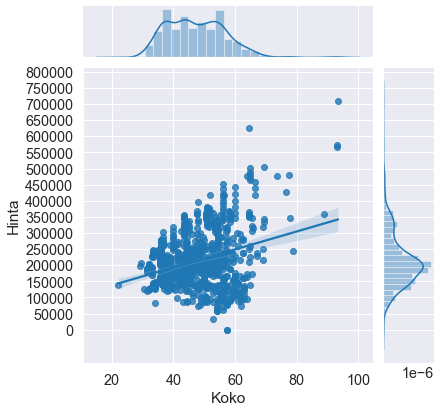

<Figure size 2160x1440 with 0 Axes>

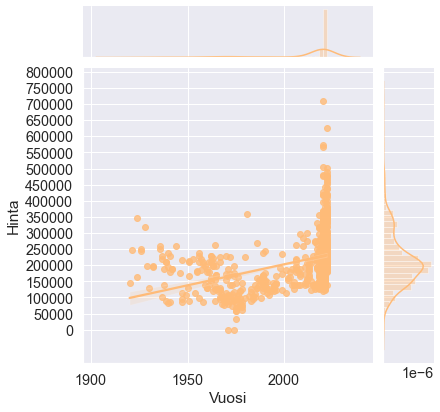

<Figure size 2160x1440 with 0 Axes>

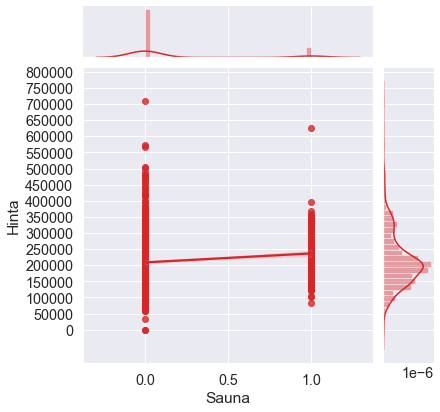

<Figure size 2160x1440 with 0 Axes>

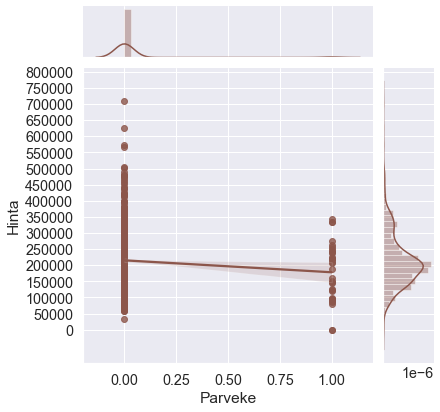

<Figure size 2160x1440 with 0 Axes>

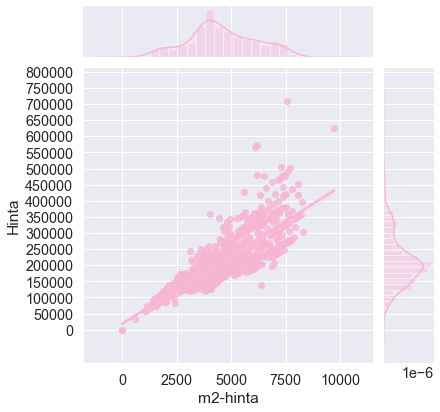

<Figure size 2160x1440 with 0 Axes>

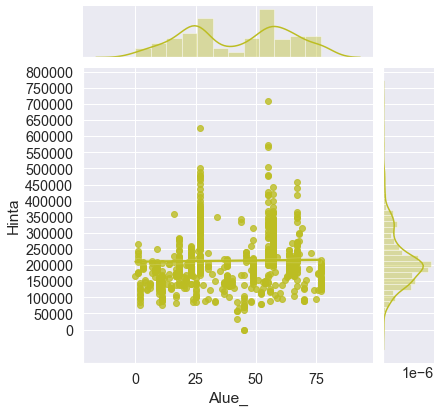

<Figure size 2160x1440 with 0 Axes>

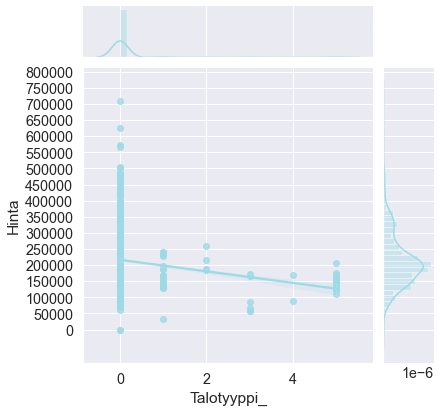

In [57]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(X.columns))];
for i,c in zip(X,colors):
    plt.style.use('seaborn-dark-palette');
    plt.figure(figsize=(30,20));
    sns.jointplot(x=i, y='Hinta', data=df, kind="reg",color=c);
    plt.xlabel(str(i));
    plt.yticks(np.arange(0,800001,50000));

## Mallien muodostaminen
### Regressiomallit

In [58]:
y = df.Hinta
#X = encoded_df.drop('Hinta', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

#### sklearn

In [59]:
time_start = time.time()

regr = LinearRegression()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.016 seconds

Training RMSE: 13949.3775
Testing RMSE: 14655.5745

Training R2: 0.9723
Testing R2: 0.9654


#### XGBoost

In [60]:
time_start = time.time()

regr = XGBRegressor()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.2999 seconds

Training RMSE: 583.8775
Testing RMSE: 6256.2105

Training R2: 1.0
Testing R2: 0.9937


In [61]:
ft_weights = pd.DataFrame(regr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights.sort_values('weight', ascending=False, inplace=True)
ft_weights.head(len(X_train.columns))

weight
m2-hinta     0.622863
Koko         0.367983
Alue_        0.003499
Vuosi        0.002101
Sauna        0.001406
Talotyyppi_  0.001352
Parveke      0.000796

### Luokittelumallit

In [62]:
y = le.fit_transform(df.Alue)
X_clf = df.drop(['Alue', 'Osoite', 'Talotyyppi', 'm2-hinta', 'Alue_'], axis=1)

#y = l_encoder.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X_clf, y, random_state=5)
', '.join(X_clf.columns)

'Hinta, Koko, Vuosi, Sauna, Parveke, Talotyyppi_'

#### RandomForestClassifier

In [63]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train, )
result = rf_clf.predict(X_test)
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

Confusion Matrix :
[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 14]]
Accuracy Score : 0.6115702479338843
Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.33      0.50      0.40         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          10       0.43      1.00      0.60         3
          11       0.22      0.40      0.29         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.0

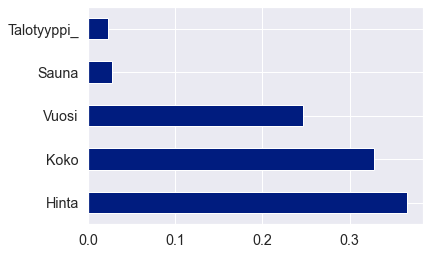

In [64]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

#### XGBClassifier

In [65]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, )
result = xgb_clf.predict(X_test)
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

Confusion Matrix :
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 16]]
Accuracy Score : 0.6115702479338843
Report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          10       0.29      0.67      0.40         3
          11       0.17      0.20      0.18         5
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.0

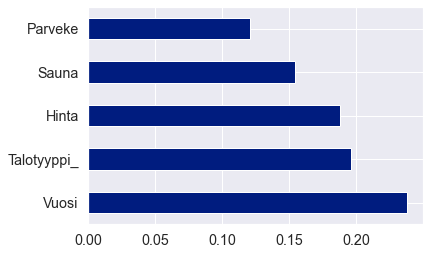

In [66]:
feat_importances = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

### Mallien testaus

In [67]:
test_values = {
    'Hinta': [150000],
    'Koko': [50],
    'Vuosi': [2020],
    'Sauna': [0],
    'Parveke': [0],
    'Talotyyppi_': [0]
}

test_values = pd.DataFrame(test_values)

In [68]:
rf_result = rf_clf.predict(test_values)
inverted = le.inverse_transform(rf_result)
print('RandomForests prediction: ',', '.join(inverted))
print(df.loc[ df['Alue'].isin(inverted) ].describe(), '\n' )

xgb_result = xgb_clf.predict(test_values)
inverted = le.inverse_transform(xgb_result)
print('XGBs prediction: ',', '.join(inverted))
print(df.loc[ df['Alue'].isin(inverted) ].describe() )

RandomForests prediction:  Haukiluoma
               Hinta       Koko        Vuosi     m2-hinta  Alue_  Talotyyppi_
count      17.000000  17.000000    17.000000    17.000000   17.0    17.000000
mean   137941.176471  45.735294  2011.588235  3096.193752   10.0     0.588235
std     19863.504815   7.518971    15.787886   633.684329    0.0     1.660528
min     85000.000000  34.000000  1977.000000  1666.666667   10.0     0.000000
25%    129000.000000  43.500000  2020.000000  3186.813187   10.0     0.000000
50%    145000.000000  45.500000  2020.000000  3195.402299   10.0     0.000000
75%    152000.000000  45.500000  2020.000000  3494.505495   10.0     0.000000
max    159000.000000  63.000000  2020.000000  3852.941176   10.0     5.000000 

XGBs prediction:  Vuores
               Hinta       Koko        Vuosi     m2-hinta  Alue_  Talotyyppi_
count      75.000000  75.000000    75.000000    75.000000   75.0         75.0
mean   151453.360000  41.146667  2019.960000  3699.319737   77.0          0.0

## Hyödyllisiä lähteitä
Data
* https://www.etuovi.com/myytavat-asunnot/tampere

Mallit
* https://www.geeksforgeeks.org/regression-classification-supervised-machine-learning/

Ominaisuuksien erittely
* https://scikit-learn.org/stable/modules/feature_selection.html
* https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
* https://www.kaggle.com/darkside92/detailed-examination-for-house-price-top-10

Raapiminen
* https://towardsdatascience.com/looking-for-a-house-build-a-web-scraper-to-help-you-5ab25badc83e

XGB
* https://github.com/gracecarrillo/Predicting-Airbnb-prices-with-machine-learning-and-location-data/blob/gh-pages/Exploring_Edinburgh_Graciela_Carrillo.ipynb



## Helpot ja vaikeat asiat
* Koodauksen kannalta homma oli joissain määrin tuttua, joten tekninen puoli sujui aika huomaamatta joitain ongelmakohtia lukuunottamatta
* 